In [ ]:
import numpy as np

In [ ]:
exampledata = np.load('/data/group_data/rl/craftax_unlabelled_new/trajectories_batch_000000.npz')

In [3]:
exampledata.files

['obs', 'next_obs', 'action', 'reward', 'done', 'log_prob']

In [4]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, AutoProcessor
from PIL import Image

(130, 110, 3)


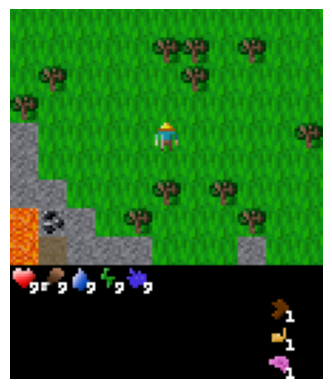

In [5]:
import matplotlib.pyplot as plt
print(exampledata['obs'][0].shape)
# visualize obs
img1_data = (exampledata['obs'][0] * 255).astype(np.uint8)
img1 = Image.fromarray(img1_data)
img2_data = (exampledata['obs'][1] * 255).astype(np.uint8)
img2 = Image.fromarray(img2_data)
plt.imshow(img1_data)
plt.axis('off')  # Optional: hides the axes
plt.show()

In [6]:
from transformers import Qwen3VLForConditionalGeneration

In [7]:
model_id = "Qwen/Qwen3-VL-4B-Instruct"
device = "cuda"

In [8]:
# quantization_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_compute_dtype=torch.float16
# )

In [9]:
import flash_attn

In [13]:
model = Qwen3VLForConditionalGeneration.from_pretrained(
    model_id,
    dtype=torch.float16,              # Load weights in float16
    quantization_config=None,  # or quantization_config
    attn_implementation="flash_attention_2", # Use FlashAttention 2
    device_map="auto",
    trust_remote_code=True                    # <-- STILL REQUIRED
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.


In [15]:
processor = AutoProcessor.from_pretrained(
    model_id,
    trust_remote_code=True
)

In [27]:
messages = [
    [{
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": img1,
            },
            {"type": "text", "text": "Describe this image."},
        ],
    }],
    [{
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": img2,
            },
            {"type": "text", "text": "Describe this image."},
        ],
    }]]
    # ,
#     [{
#         "role": "user",
#         "content": [
#             {
#                 "type": "image",
#                 "image": "/home/geney/testing_vlms/images/2.png",
#             },
#             {"type": "text", "text": "Describe this image."},
#         ],
#     }],
#     [{
#         "role": "user",
#         "content": [
#             {
#                 "type": "image",
#                 "image": "/home/geney/testing_vlms/images/3.png",
#             },
#             {"type": "text", "text": "Describe this image."},
#         ],
#     }],
#     [{
#         "role": "user",
#         "content": [
#             {
#                 "type": "image",
#                 "image": "/home/geney/testing_vlms/images/4.png",
#             },
#             {"type": "text", "text": "Describe this image."},
#         ],
#     }]
# ]

In [28]:
# duplicatedmessages = messages + messages + messages + messages + messages + messages + messages + messages
# print(len(duplicatedmessages))
inputs = processor.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_dict=True,
    return_tensors="pt",
    padding=True
)
inputs = inputs.to(model.device)

In [31]:
import time

start_perf_counter = time.perf_counter()
outputs = model.generate(**inputs, max_new_tokens=256, output_hidden_states=True, return_dict_in_generate=True)
end_perf_counter = time.perf_counter()
print(end_perf_counter - start_perf_counter)

final_hidden_state = outputs.hidden_states[-1][-1]
print(final_hidden_state.shape)
generated_ids = outputs.sequences
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
for i in range(len(output_text)):
    print(str(i+1))
    print(output_text[i])
    print()

7.126316556008533
torch.Size([2, 1, 2560])
1
This image is a screenshot from a classic 2D side-scrolling video game, likely from the early 1990s, featuring a pixel-art style. The scene depicts a small, yellow, humanoid character standing on a green grassy field with scattered brown trees. To the left, there is a gray stone path or wall, and a small orange block or structure is visible near the bottom left.

At the bottom of the screen, there is a status bar with several icons and numbers:

- On the left, a red heart icon with the number "9" next to it, indicating the player's health or lives.
- Next to the heart, there are three icons: a blue potion, a purple potion, and a yellow item (possibly a key or special item), each with the number "9" beside them, likely indicating quantities of these items.
- On the right side of the status bar, there are two icons: a brown object (possibly a tool or weapon) with the number "2" next to it, and a pink object (perhaps a flower or another item) w

In [16]:
prompt_text = "Think about what the character in the center of the image should do next, keeping in mind the health, hunger, thirst, and energy levels displayed on the screen. Provide a detailed action plan for the next steps the character should take to ensure survival and progress in the game."
num_images = 20

In [17]:
messages = []
for i in range(num_images):
    img_data = (exampledata['obs'][i] * 255).astype(np.uint8)
    img = Image.fromarray(img_data)
    messages.append(
        [{
            "role": "user",
            "content": [
                {"type": "image", "image": img},
                {"type": "text", "text": prompt_text},
            ],
        }]
    )

In [18]:
inputs = processor.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_dict=True,
    return_tensors="pt",
    padding=True
)
inputs = inputs.to(model.device)

In [19]:
token_lengths_to_test = [1, 8, 32, 40, 256]
results = {}

In [21]:
from sklearn.metrics.pairwise import cosine_similarity
import time
for n_tokens in token_lengths_to_test:
    print(f"Testing with max_new_tokens = {n_tokens}...")
    start_time = time.perf_counter()
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs, 
            max_new_tokens=n_tokens, 
            output_hidden_states=True, 
            return_dict_in_generate=True
        )
        
        generated_ids = outputs.sequences
        # Get all generated sequences, trimming the input IDs
        generated_ids_trimmed = [
            out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
        ]
        # Decode just the first one
        output_text = processor.batch_decode(
            [generated_ids_trimmed[0]], # Pass a list with just the first trimmed sequence
            skip_special_tokens=True, 
            clean_up_tokenization_spaces=False
        )
        print(f"  First response ({n_tokens} tokens): {output_text[0]}")

        hidden_states_at_step_n = outputs.hidden_states[n_tokens - 1]
        last_layer_hidden_states = hidden_states_at_step_n[-1]
        final_token_hidden_states = last_layer_hidden_states[:, -1, :]
        print(final_token_hidden_states.shape)
        hs_numpy = final_token_hidden_states.cpu().numpy().astype(np.float32) # Use float32 for sklearn
        indices = np.triu_indices(num_images, k=1)
        
        if hs_numpy.shape[0] == num_images:
            cosine_sim_matrix = cosine_similarity(hs_numpy)
            avg_sim = np.mean(cosine_sim_matrix[indices])
            
            end_time = time.perf_counter()
            print(f"  Average Cosine Similarity: {avg_sim:.4f} (Time: {end_time - start_time:.2f}s)")
            results[n_tokens] = avg_sim
        else:
            print(f"  Error: Expected batch size {num_images} but got {hs_numpy.shape[0]}")

Testing with max_new_tokens = 1...
  First response (1 tokens): Based
torch.Size([20, 2560])
  Average Cosine Similarity: 0.9986 (Time: 0.83s)
Testing with max_new_tokens = 8...
  First response (8 tokens): Based on the game state shown in the
torch.Size([20, 2560])
  Average Cosine Similarity: 0.8464 (Time: 1.41s)
Testing with max_new_tokens = 32...
  First response (32 tokens): Based on the game state shown in the image, here’s a detailed action plan for the character to ensure survival and progress:

---

**Current Status (from UI
torch.Size([20, 2560])
  Average Cosine Similarity: 0.5595 (Time: 4.81s)
Testing with max_new_tokens = 40...
  First response (40 tokens): Based on the image, here’s a detailed action plan for the character’s next steps to ensure survival and progress:

---

**Current Status (from UI):**
- **Health:** 1 heart (
torch.Size([20, 2560])
  Average Cosine Similarity: 0.4068 (Time: 6.13s)
Testing with max_new_tokens = 256...
  First response (256 tokens): Based 

{1: np.float32(0.9986418), 8: np.float32(0.7009412), 32: np.float32(0.4338321), 40: np.float32(0.43876898), 256: np.float32(0.47946718)}


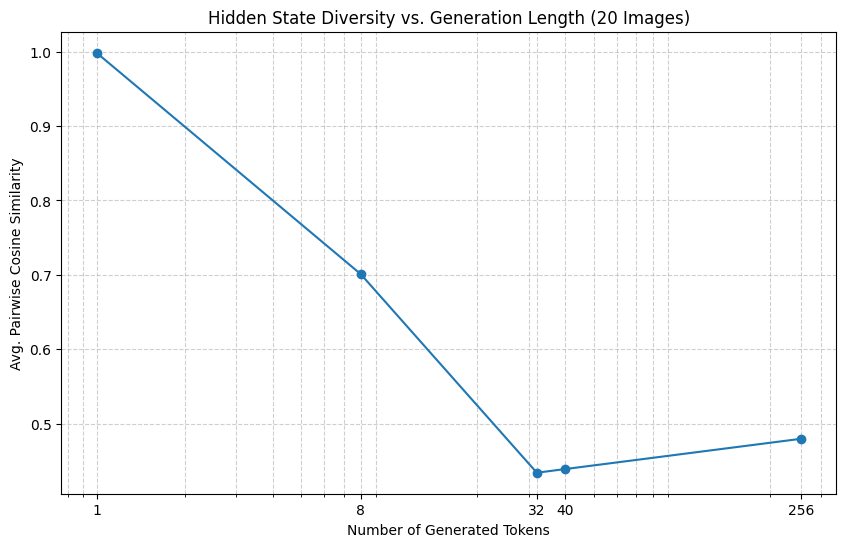

In [74]:
token_lengths = sorted(results.keys())
similarities = [results[k] for k in token_lengths]

plt.figure(figsize=(10, 6))
plt.plot(token_lengths, similarities, marker='o', linestyle='-')
plt.xlabel("Number of Generated Tokens")
plt.ylabel("Avg. Pairwise Cosine Similarity")
plt.title(f"Hidden State Diversity vs. Generation Length ({num_images} Images)")
plt.xscale('log')
plt.xticks(token_lengths, labels=token_lengths) # Set explicit ticks
plt.grid(True, which="both", ls="--", alpha=0.6)

print(results)